In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

def poisson_random_process(lmbda, total_time):
    """
    Generate a Poisson random process.
    
    Parameters:
        lmbda (float): The parameter lambda of the Poisson distribution.
        total_time (float): The total time for the process.
    
    Returns:
        numpy.ndarray: An array of timestamps when events occur.
    """
    num_events = np.random.poisson(lmbda * total_time)
    event_times = np.cumsum(np.random.exponential(1 / lmbda, num_events))
    event_times = event_times[event_times < total_time]
    return event_times



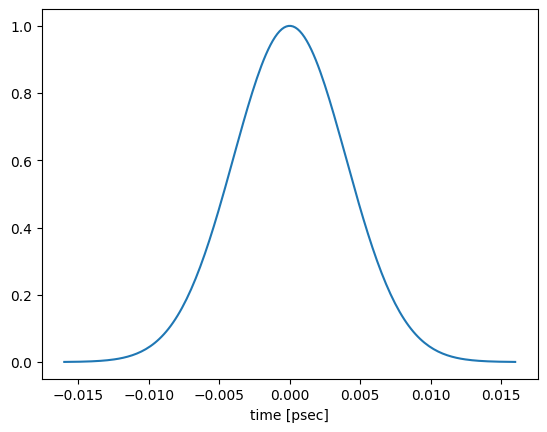

In [2]:
## HOM for partially distinguishable photons
hom_coincidence = lambda x, dw: np.exp(-(x*dw) **2/2 ) 
dw = 250 # GHz
x = np.linspace(-1,1,200)*4/dw
plt.plot(x, hom_coincidence(x,dw))
plt.xlabel("time [psec]")
plt.show()

# Success probability per time slot

In [3]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time_list = np.logspace(-5,-1,12)  # Total time in sec for the process
dw = 10**10

reset_time_list = [1e-8,1e-6,3e-6,1e-5]

Nrep = 1000
succ_prob = np.zeros((len(total_time_list),len(reset_time_list), Nrep))
for i_t, total_time in enumerate(total_time_list):
    tic = time.time()
    for i_reset, reset_time in enumerate(reset_time_list):
        for i_r in range(Nrep):
        # print(i_r, end="\r")
            s1 = poisson_random_process(gen_rate, total_time)
            s2 = poisson_random_process(gen_rate, total_time)

            num_trials = min(s1.shape[0],s2.shape[0])
            # num_trials
            all_events = np.concatenate((s1,s2))
            events_inds = all_events.argsort()
            all_events = all_events[events_inds]
            emissions = np.zeros(events_inds.shape[0], dtype=np.int32)
            emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

            # time_diff = []

            qu_reset = [False, False]
            qu_avaialble_time = [0,0]
            i_trial = 0
            while i_trial < len(emissions)-1:
                if all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                    qu_reset[emissions[i_trial]] = False
                    qu_avaialble_time[emissions[i_trial]] = 0
                
                if emissions[i_trial+1]== 1- emissions[i_trial]:
                    if all_events[i_trial+1] >= qu_avaialble_time[emissions[i_trial+1]]:
                        qu_reset[emissions[i_trial+1]] = False
                        qu_avaialble_time[emissions[i_trial+1]] = 0

                    if (not qu_reset[0])*(not qu_reset[1]):
                        dt = all_events[i_trial+1]-all_events[i_trial]
                        prob = 0.5* hom_coincidence(dt,dw) # 0.5 for BSM post selection
                        if np.random.rand()< prob: # accept with probability p
                    #     ## check if BSM can be performed
                            ## BSM measurement
                            succ_prob[i_t,i_reset,i_r] = 1
                            break
                        # i_trial += 2
                        
                # ## shift timer
                # new_avail_time = all_events[i_trial]+reset_time
                if  all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                    qu_reset[emissions[i_trial]] = True
                    qu_avaialble_time[emissions[i_trial]] = all_events[i_trial]+reset_time
                    
                i_trial += 1

                # if emissions[i_trial+1]== 1- emissions[i_trial]:
                #     dt = all_events[i_trial+1]-all_events[i_trial]
                #     prob = 0.5* hom_coincidence(dt,dw) # 0.5 for BSM post selection
                #     if np.random.rand()< prob: # accept with probability p
                #     #     ## check if BSM can be performed
                #         if (not qu_reset[0])*(not qu_reset[1]):
                #             ## BSM measurement
                #             succ_prob[i_t,i_reset,i_r] = 1
                #             break
                #         # i_trial += 2
                        
                # # ## shift timer
                # # new_avail_time = all_events[i_trial]+reset_time
                # if  all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                #     qu_reset[emissions[i_trial]] = True
                #     qu_avaialble_time[emissions[i_trial]] = all_events[i_trial]+reset_time
                    
                # i_trial += 1
                # if all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                #     qu_reset[emissions[i_trial]] = False
                #     qu_avaialble_time[emissions[i_trial]] = 0
                # # print(qu_reset, qu_avaialble_time)

    toc = time.time()
    print(f"({i_t}), elapsed time {toc-tic} sec")



(0), elapsed time 0.5611896514892578 sec
(1), elapsed time 0.8775675296783447 sec
(2), elapsed time 1.880936861038208 sec
(3), elapsed time 4.294050455093384 sec
(4), elapsed time 9.920865535736084 sec
(5), elapsed time 22.878326416015625 sec
(6), elapsed time 51.747360944747925 sec
(7), elapsed time 116.0868661403656 sec
(8), elapsed time 246.53816723823547 sec
(9), elapsed time 483.6751093864441 sec
(10), elapsed time 900.021829366684 sec
(11), elapsed time 1626.1215109825134 sec


In [19]:
fname = f"results/prob_vs_timeslot_1ghz_hom_qreset.npz"
# fname = f"results/prob_vs_timeslot_hom_qreset.npz"
np.savez(fname,gen_rate, total_time_list,
         reset_time_list,
         succ_prob)

In [2]:
# fname = f"results/prob_vs_timeslot_hom_qreset.npz"
fname = f"results/prob_vs_timeslot_1ghz_hom_qreset.npz"
f1 = np.load(fname)
gen_rate = f1['arr_0'] 
total_time_list = f1['arr_1'] 
reset_time_list =  f1['arr_2'] 
succ_prob = f1['arr_3'] 



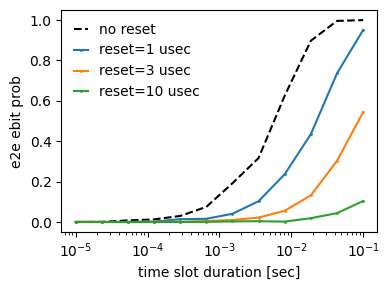

In [11]:
plt.figure(figsize=(4,3))
# for i_reset, reset_time in enumerate(reset_time_list):
#     plt.plot(total_time_list, (succ_prob[:,i_reset,:]).mean(axis=-1), ".-",markersize=2, color = f"C{i_reset}", label=fr"reset={reset_time*1e6:.0f} usec")
for i_reset, _ in enumerate(reset_time_list):
    reset_time = reset_time_list[i_reset]
    if i_reset>0:
        plt.plot(total_time_list, (succ_prob[:,i_reset,:]).mean(axis=-1), ".-",markersize=4, linewidth=1.5, color = f"C{i_reset}", label=fr"reset={reset_time*1e6:.0f} usec")
    else:
        plt.plot(total_time_list, (succ_prob[:,i_reset,:]).mean(axis=-1), "k--" label="no reset")#, color = f"C{i_reset}", label=fr"reset={reset_time*1e6:.0f} usec")

    # plt.plot(total_time_list, succ_prob[:,i_reset,:], ".",markersize=2, color = f"C{i_reset}")

plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"time slot duration [sec]")
plt.ylabel("e2e ebit prob")
# plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
plt.savefig("figures/"+fname.split("/")[-1].split(".")[0]+".pdf")
# plt.savefig("figures/rate_vs_delay_w_loss_dense.pdf")
# plt.savefig("figures/rate_vs_delay_baseline.pdf")
plt.show()


In [3]:
fname_no_reset = f"results/prob_vs_timeslot_hom_dense.npz"
f1 = np.load(fname_no_reset)
gen_rate_no_reset  = f1['arr_0'] 
total_time_list_no_reset = f1['arr_1'] 
linewidth_list_no_reset  =  f1['arr_2'] 
succ_prob_no_reset  = f1['arr_3'] 

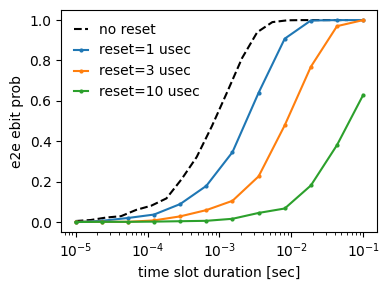

In [7]:
plt.figure(figsize=(4,3))

plt.plot(total_time_list_no_reset, (succ_prob_no_reset[:,0,:]).mean(axis=-1), "k--", linewidth=1.5, label="no reset")#, color = f"C{i_reset}", label=fr"reset={reset_time*1e6:.0f} usec")
for i_reset, reset_time in enumerate(reset_time_list):
    plt.plot(total_time_list, (succ_prob[:,i_reset,:]).mean(axis=-1), ".-",markersize=4, linewidth=1.5, color = f"C{i_reset}", label=fr"reset={reset_time*1e6:.0f} usec")
    # plt.plot(total_time_list, succ_prob[:,i_reset,:], ".",markersize=2, color = f"C{i_reset}")

fname_no_reset = f"results/prob_vs_timeslot_hom_dense.npz"
f1_no_reset = np.load(fname_no_reset)
gen_rate_no_reset = f1_no_reset['arr_0'] 
total_time_list_no_reset = f1_no_reset['arr_1'] 
linewidth_list_no_reset =  f1_no_reset['arr_2'] 
succ_prob_no_reset = f1_no_reset['arr_3'] 


plt.xscale("log")
# plt.yscale("log")
plt.xlabel(r"time slot duration [sec]")
plt.ylabel("e2e ebit prob")
# plt.ylim([1e1,1e6])
plt.legend(frameon=False, handlelength=1)
# plt.grid()
plt.tight_layout()
plt.savefig("figures/"+fname.split("/")[-1].split(".")[0]+".pdf")
plt.show()


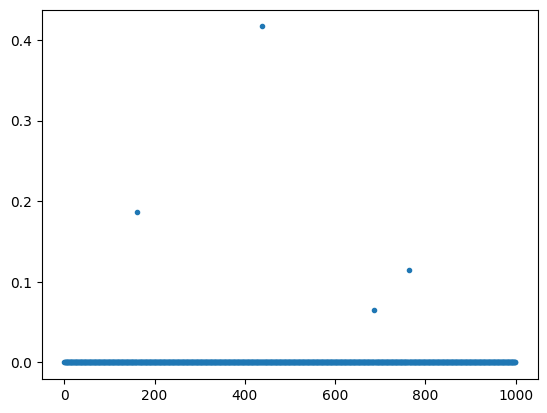

In [45]:
plt.plot(succ_prob[-1,0,:],".")

## distribution of generation times

In [53]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-1  # Total time in sec for the process
dw = 10*1e9 # photon linewidth in GHz

reset_time_list = [1e-6]

Nrep = 10000
succ_time = np.zeros((len(reset_time_list), Nrep))
for i_reset, reset_time in enumerate(reset_time_list):
    tic = time.time()
    for i_r in range(Nrep):
    # print(i_r, end="\r")
        s1 = poisson_random_process(gen_rate, total_time)
        s2 = poisson_random_process(gen_rate, total_time)

        num_trials = min(s1.shape[0],s2.shape[0])
        # num_trials
        all_events = np.concatenate((s1,s2))
        events_inds = all_events.argsort()
        all_events = all_events[events_inds]
        emissions = np.zeros(events_inds.shape[0], dtype=np.int32)
        emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

        # time_diff = []

        qu_reset = [False, False]
        qu_avaialble_time = [0,0]
        i_trial = 0
        while i_trial < len(emissions)-1:
            if all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                qu_reset[emissions[i_trial]] = False
                qu_avaialble_time[emissions[i_trial]] = 0
            
            if emissions[i_trial+1]== 1- emissions[i_trial]:
                if all_events[i_trial+1] >= qu_avaialble_time[emissions[i_trial+1]]:
                    qu_reset[emissions[i_trial+1]] = False
                    qu_avaialble_time[emissions[i_trial+1]] = 0

                if (not qu_reset[0])*(not qu_reset[1]):
                    dt = all_events[i_trial+1]-all_events[i_trial]
                    prob = 0.5* hom_coincidence(dt,dw) # 0.5 for BSM post selection
                    if np.random.rand()< prob: # accept with probability p
                #     ## check if BSM can be performed
                        ## BSM measurement
                        succ_time[i_reset,i_r] = all_events[i_trial+1]
                        break
                    # i_trial += 2
                    
            # ## shift timer
            # new_avail_time = all_events[i_trial]+reset_time
            if  all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
                qu_reset[emissions[i_trial]] = True
                qu_avaialble_time[emissions[i_trial]] = all_events[i_trial]+reset_time
                
            i_trial += 1


    toc = time.time()
    print(f"({i_reset}), elapsed time {toc-tic} sec")



(0), elapsed time 2972.6006121635437 sec


In [5]:
def hist(x, num_bins, label):
    n, bin_edges = np.histogram(x, bins=num_bins)
    bins_center= (bin_edges[0:num_bins]+ bin_edges[1:])/2
    n= n/np.sum(n)/(bin_edges[1]-bin_edges[0])
    plt.plot(bins_center,n,'-',markersize=2,label=label)
    return bins_center

(9565, 1)
0.05007336447596756


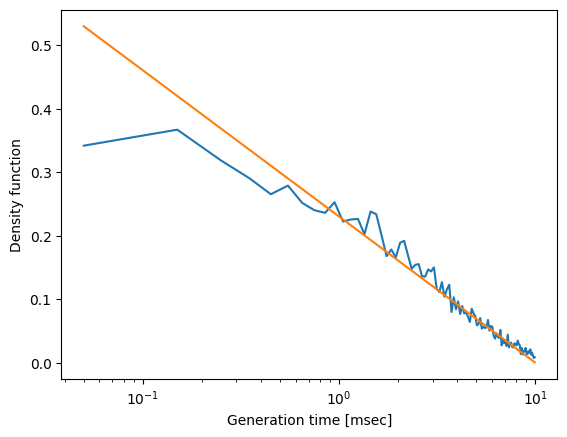

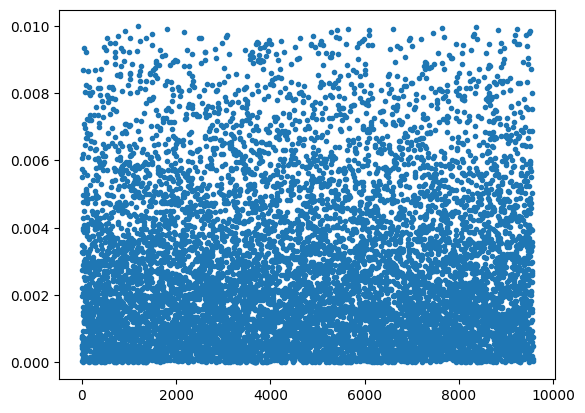

In [52]:
for i_reset, reset_time in enumerate(reset_time_list):
    succ_time_pp = succ_time[i_reset,np.argwhere(succ_time[i_reset,:]>0)]
    print(succ_time_pp.shape)
    bins = hist(succ_time_pp*1e3, 100, " ")
    print(bins[0])
    plt.plot(bins,0.23-0.1*np.log((bins)))
    plt.xlabel("Generation time [msec]")
    plt.xscale("log")
    plt.ylabel("Density function")
    plt.show()
    plt.plot(succ_time_pp,".")
plt.show()

(9543, 1)
0.4994399848695151


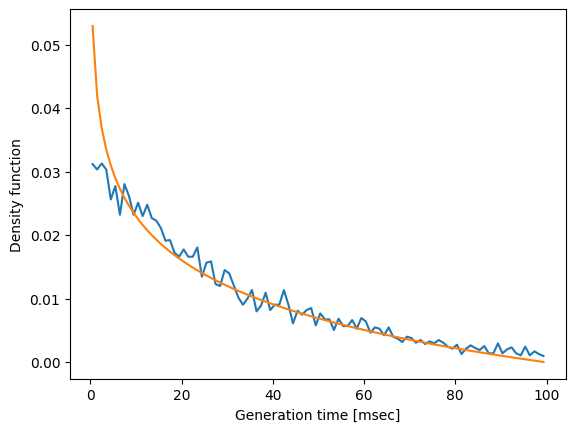

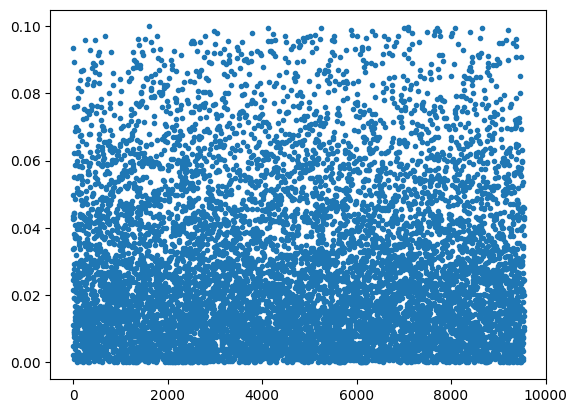

In [62]:
for i_reset, reset_time in enumerate(reset_time_list):
    succ_time_pp = succ_time[i_reset,np.argwhere(succ_time[i_reset,:]>0)]
    print(succ_time_pp.shape)
    bins = hist(succ_time_pp*1e3, 100, " ")
    print(bins[0])
    plt.plot(bins,0.046-0.01*np.log((bins)))
    plt.xlabel("Generation time [msec]")
    # plt.xscale("log")
    plt.ylabel("Density function")
    plt.show()
    plt.plot(succ_time_pp,".")
plt.show()

## sanity checks

In [76]:
gen_rate = 1e6 # Parameter lambda in Hz
total_time = 1e-1  # Total time in sec for the process
dw = 10**9

reset_time = 1e-6

# print(i_r, end="\r")
s1 = poisson_random_process(gen_rate, total_time)
s2 = poisson_random_process(gen_rate, total_time)

num_trials = min(s1.shape[0],s2.shape[0])
# num_trials
all_events = np.concatenate((s1,s2))
events_inds = all_events.argsort()
all_events = all_events[events_inds]
emissions = np.zeros(events_inds.shape[0], dtype=np.int32)
emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

succ_prob = 0
qu_reset = [False, False]
qu_avaialble_time = [0,0]
i_trial = 0
while i_trial < len(emissions)-1:

    if emissions[i_trial+1]== 1- emissions[i_trial]:
        dt = all_events[i_trial+1]-all_events[i_trial]
        prob = 0.5* hom_coincidence(dt,dw) # 0.5 for BSM post selection
        if np.random.rand()< prob: # accept with probability p
        #     ## check if BSM can be performed
            if (not qu_reset[0])*(not qu_reset[1]):
                ## BSM measurement
                succ_prob[i_t,i_reset,i_r] = 1
                break
            # i_trial += 2
            
    # ## shift timer
    # new_avail_time = all_events[i_trial]+reset_time
    if  all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
        qu_reset[emissions[i_trial]] = True
        qu_avaialble_time[emissions[i_trial]] = all_events[i_trial]+reset_time
        
    i_trial += 1
    if all_events[i_trial] >= qu_avaialble_time[emissions[i_trial]]:
        qu_reset[emissions[i_trial]] = False
        qu_avaialble_time[emissions[i_trial]] = 0
    # print(qu_reset, qu_a
print(succ_prob)

0


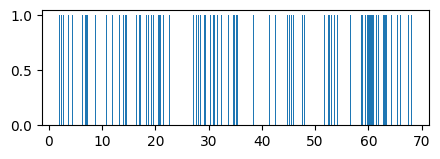

<BarContainer object of 97 artists>

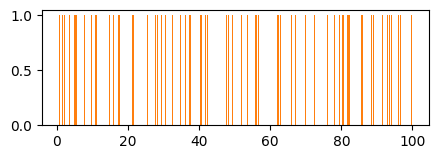

In [68]:
plt.figure(figsize=(5,1.5))
plt.bar(s1*1e6,1,width=2e-1)
plt.show()
plt.figure(figsize=(5,1.5))
plt.bar(s2*1e6,1,width=2e-1,color="C1")


In [6]:
## sanity check

s1 = np.array([1,3,10,14])
s2 = np.array([2,5,7,8,12])
all_events = np.concatenate((s1,s2))
events_inds = all_events.argsort()
all_events = all_events[events_inds]
emissions = np.zeros(events_inds.shape[0])
emissions[np.argwhere(events_inds>=s1.shape[0])] = 1

print(all_events)
print(emissions)


[ 1  2  3  5  7  8 10 12 14]
[0. 1. 0. 1. 1. 1. 0. 1. 0.]
